<a href="https://colab.research.google.com/github/MicheleBonus/cpclab_notebooks/blob/main/visualize_ligand_interactions_for_uniprot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---- Required Libraries ----
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def fetch_data_from_url(endpoint, id, base_url="https://www.ebi.ac.uk/pdbe/graph-api"):
    """
    Fetches data from the PDBe API using the specified endpoint and ID.

    Parameters:
    - endpoint (str): The endpoint of the API.
    - id (str): The ID used in the API query.
    - base_url (str, optional): The base URL for the API. Defaults to "https://www.ebi.ac.uk/pdbe/graph-api".

    Returns:
    - dict: Data returned from the API or None if there's an exception.
    """
    url = f"{base_url}/{endpoint}/{id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error occurred while fetching data: {e}")
        return None

In [ ]:
def extract_data_from_ligand_sites(ligand_sites):
    """
    Extracts specific ligand site information from the raw data.

    Parameters:
    - ligand_sites (dict): Data containing ligand sites information.

    Returns:
    - list: List of dictionaries containing extracted data.
    """
    extracted_data = []
    for data_uniprot_accession, accession_data in ligand_sites.items():
        for row in accession_data.get('data', []):
            for residue in row.get('residues', []):
                # Add extra fields to the residue data
                residue['ligand_accession'] = row.get('accession')
                residue['ligand_name'] = row.get('name')
                residue['ligand_num_atoms'] = row.get('additionalData', {}).get('numAtoms')
                residue['uniprot_accession'] = data_uniprot_accession
                residue['interaction_ratio'] = len(residue.get('interactingPDBEntries', [])) / len(residue.get('allPDBEntries', []))
                extracted_data.append(residue)
    return extracted_data

In [ ]:
def extract_data_from_ligands(ligands_data):
    """
    Extracts ligand information from the raw data.

    Parameters:
    - ligands_data (dict): Data containing ligands information.

    Returns:
    - list: List of dictionaries containing extracted data.
    """
    extracted_data = []
    for data_uniprot_accession, accession_data in ligands_data.items():
        for ligand_row in accession_data:
            for ligand, attributes in ligand_row.items():
                attributes['pdbs'] = ",".join(attributes['pdbs'])
                attributes['acts_as'] = ",".join([item.strip() for item in attributes['acts_as']])
                # Merge ligand code with its attributes
                extracted_data.append({"ligand_code": ligand, **attributes})
    return extracted_data

In [ ]:
def visualize_ligand_interactions(df_avg_interactions, ligands_of_interest, include_not_of_interest=False):
    """
    Visualize the interaction of residues with ligands.

    Parameters:
    - df_avg_interactions (pd.DataFrame): Data containing average interactions.
    - ligands_of_interest (list): List of ligands that are of special interest.
    - include_not_of_interest (bool): Whether to include ligands not of interest in the visualization.
    """

    plt.rcParams['figure.figsize'] = [12, 12]
    fig, ax = plt.subplots()

    # Plot ligands that are not of interest in blue, if include_not_of_interest is True
    if include_not_of_interest:
        ligands_not_of_interest = set(df_avg_interactions['ligand_accession']) - set(ligands_of_interest)
        for ligand in ligands_not_of_interest:
            interaction_data = df_avg_interactions[df_avg_interactions['ligand_accession'] == ligand]
            interaction_data.plot.scatter(x='residue_number', y='ligand_accession', ax=ax,
                                          s=interaction_data['interaction_ratio']*200, c='blue', alpha=0.6, label=f'Not of Interest: {ligand}')

    # Plot ligands of interest in red
    for ligand in ligands_of_interest:
        interaction_data = df_avg_interactions[df_avg_interactions['ligand_accession'] == ligand]
        interaction_data.plot.scatter(x='residue_number', y='ligand_accession', ax=ax,
                                      s=interaction_data['interaction_ratio']*200, c='red', label=f'Of Interest: {ligand}')

    plt.ylabel('Ligand')
    plt.xlabel('UniProt Residue Number')
    plt.title('Residues which interact with ligands,\nSpheres scaled by interaction ratio in PDB entries')
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()
    plt.close()

In [ ]:
def main(uniprot_id, threshold_multiplier=2, base_url="https://www.ebi.ac.uk/pdbe/graph-api"):
    """
    Main function to fetch, process, and analyze ligand interaction data for a given UniProt ID.

    Parameters:
    - uniprot_id (str): The UniProt ID for which data should be fetched and analyzed.
    - threshold_multiplier (float, optional): Multiplier for the standard deviation to determine the threshold for interactions. Defaults to 2.
    - base_url (str, optional): The base URL for the API. Defaults to "https://www.ebi.ac.uk/pdbe/graph-api".

    Returns:
    - pd.DataFrame: DataFrame containing the average interactions for each residue-ligand pair.
    """

    # Fetching ligand sites and ligand data for the specified UniProt ID
    ligand_sites_raw_data = fetch_data_from_url("uniprot/ligand_sites", uniprot_id, base_url=base_url)
    ligands_raw_data = fetch_data_from_url("uniprot/ligands", uniprot_id, base_url=base_url)

    # Extracting relevant data from raw data
    data_from_sites = extract_data_from_ligand_sites(ligand_sites_raw_data)
    data_from_ligands = extract_data_from_ligands(ligands_raw_data)

    # Transforming ligand site data into a DataFrame
    df_sites = pd.DataFrame(data_from_sites).explode(column='interactingPDBEntries').reset_index(drop=True)
    interactions_data = pd.json_normalize(df_sites['interactingPDBEntries'])
    df_sites_enriched = df_sites.join(interactions_data).drop(columns='interactingPDBEntries')
    df_sites_enriched['residue_number'] = df_sites_enriched['startIndex']

    # Analyzing interactions: Counting interactions for each residue
    df_interactions_count = df_sites_enriched.groupby('residue_number')['pdbId'].count().reset_index()
    mean_interactions = df_interactions_count['pdbId'].mean()
    std_interactions = df_interactions_count['pdbId'].std()

    # Identifying residues with interaction counts greater than the specified standard deviations
    residues_over_threshold = df_interactions_count.query(f'pdbId > {threshold_multiplier * std_interactions}')['residue_number']
    ligands_of_interest = df_sites_enriched[df_sites_enriched['residue_number'].isin(residues_over_threshold)]['ligand_accession'].unique()

    # Transforming ligands data into a DataFrame
    df_ligands = pd.DataFrame(data_from_ligands)

    # Calculating the mean interaction ratio for each residue-ligand pair
    df_avg_interactions = df_sites_enriched.groupby(['residue_number', 'ligand_accession'])['interaction_ratio'].mean().reset_index()

    return df_avg_interactions, ligands_of_interest

In [ ]:
df_avg_interactions, ligands_of_interest = main("Q9BY41")

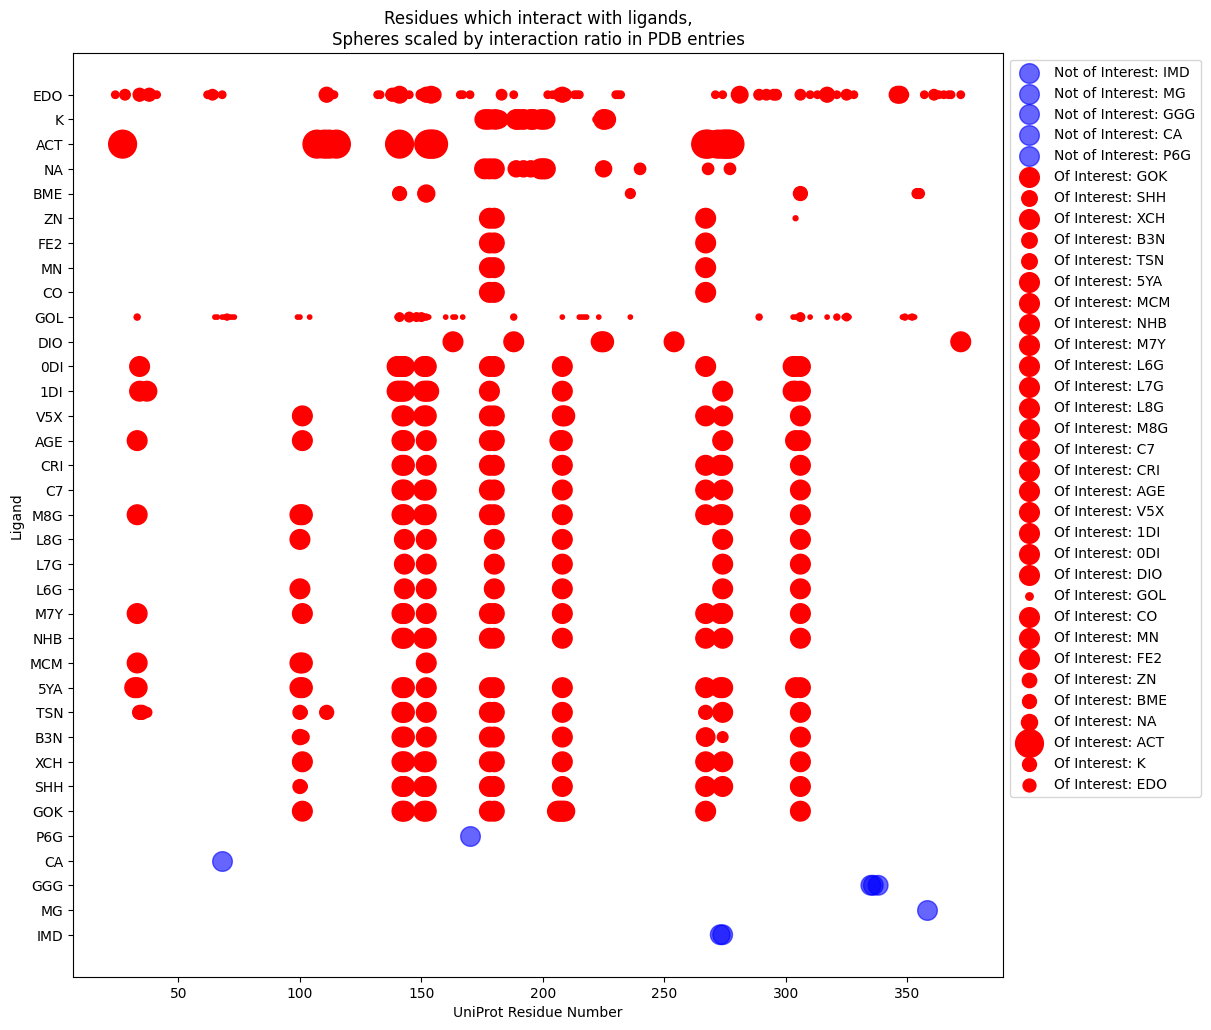

In [ ]:
visualize_ligand_interactions(df_avg_interactions, ligands_of_interest, include_not_of_interest=True)